# MLE-5-Weekly Project




In [24]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

np.random.seed(1) # set a seed so that the results are consistent

In [25]:
# Load the data from h5 file
def load_dataset():
    train_dataset = h5py.File('catsvsdogs-train.h5', "r")
    train_set_x_orig = np.array(train_dataset["images"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["labels"][:]) # your train set labels
    
    test_dataset = h5py.File('catsvsdogs-test.h5', "r")
    test_set_x_orig = np.array(test_dataset["images"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["labels"][:]) # your test set labels
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig

In [26]:
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig = load_dataset()

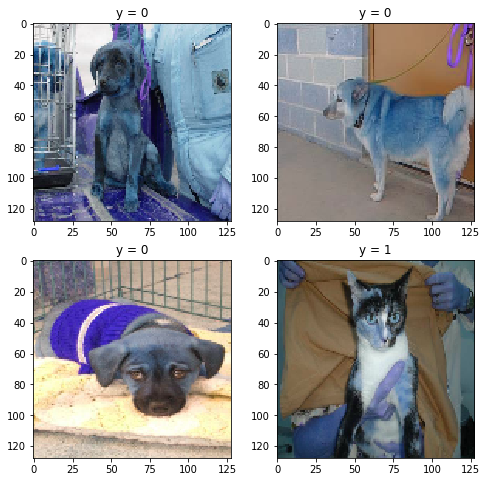

In [27]:
# Some some random images and their labels
plt.subplots(figsize = (8,8))
plt.subplot(221)
index_1 = np.random.randint(0,len(train_set_x_orig)) 
plt.imshow(train_set_x_orig[index_1])
plt.title("y = " + str(train_set_y_orig[index_1]))

plt.subplot(222)
index_2 = np.random.randint(0,len(train_set_x_orig))
plt.imshow(train_set_x_orig[index_2])
plt.title("y = " + str(train_set_y_orig[index_2]))

plt.subplot(223)
index_3 = np.random.randint(0,len(train_set_x_orig))
plt.imshow(train_set_x_orig[index_3])
plt.title("y = " + str(train_set_y_orig[index_3]))

plt.subplot(224)
index_4 = np.random.randint(0,len(train_set_x_orig))
plt.imshow(train_set_x_orig[index_4])
plt.title("y = " + str(train_set_y_orig[index_4]))

plt.show()

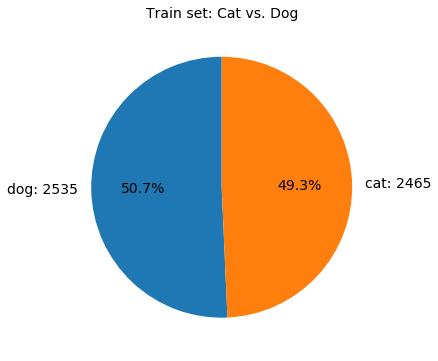

In [8]:
# Visualization the train set labels
unique, counts = np.unique(train_set_y_orig, return_counts = True)
dict1 = dict(zip(unique, counts))
plt.figure(figsize=(6,6))
plt.pie(x = counts, labels = ['dog: %s' % counts[0],'cat: %s' % counts[1]], autopct = '%1.1f%%', startangle=90, textprops={'fontsize': 14})
plt.title('Train set: Cat vs. Dog', fontdict={'fontsize': 14})
plt.show()

In [28]:
# Convert X to 2D array
X_train = train_set_x_orig.flatten().reshape((len(train_set_x_orig),-1)) / 255
X_test = test_set_x_orig.flatten().reshape((len(test_set_x_orig),-1)) / 255

# Convert y to 1D array
y_train = train_set_y_orig.reshape(1, -1)
y_test = test_set_y_orig.reshape(1, -1)

In [29]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5000, 49152), (1, 5000), (500, 49152), (1, 500))

## Building model

In this notebook, you will implement all the functions required to build a deep neural network.

![](https://i.imgur.com/ivhZhmx.png)

**Notation**:
- Superscript $[l]$ denotes a quantity associated with the $l^{th}$ layer. 
    - Example: $a^{[L]}$ is the $L^{th}$ layer activation. $W^{[L]}$ and $b^{[L]}$ are the $L^{th}$ layer parameters.
- Superscript $(i)$ denotes a quantity associated with the $i^{th}$ example. 
    - Example: $x^{(i)}$ is the $i^{th}$ training example.
- Lowerscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the $l^{th}$ layer's activations).
    
The initialization for a deeper L-layer neural network is more complicated because there are many more weight matrices and bias vectors. When completing the `initialize_params`, you should make sure that your dimensions match between each layer. Given $n^{[l]}$ is the number of units in layer $l$. Thus for example if the size of our input $X$ is $(12288, 209)$ (with $m=209$ examples) then:

| |**Shape of W**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; |**Shape of b**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|**Activation**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|**Shape of Activation**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|
|:-|:-|:-|:-|:-|
|**Layer 1**|$(n^{[1]},12288)$|$(n^{[1]},1)$|$Z^{[1]} = W^{[1]}  X + b^{[1]} $|$(n^{[1]},209)$|
| **Layer 2**|$(n^{[2]}, n^{[1]})$|$(n^{[2]},1)$|$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$|$(n^{[2]}, 209)$|
|$\vdots$| $\vdots$ | $\vdots$|$\vdots$|$\vdots$|
|**Layer L-1** | $(n^{[L-1]}, n^{[L-2]})$ | $(n^{[L-1]}, 1)$ | $Z^{[L-1]} =  W^{[L-1]} A^{[L-2]} + b^{[L-1]}$ | $(n^{[L-1]}, 209)$|
|**Layer L** | $(n^{[L]}, n^{[L-1]})$ | $(n^{[L]}, 1)$|  $Z^{[L]} =  W^{[L]} A^{[L-1]} + b^{[L]}$|$(n^{[L]}, 209)$ |

Remember that when we compute $W X + b$ in python, it carries out broadcasting. For example, if: 

$$ W = \begin{bmatrix}
    j  & k  & l\\
    m  & n & o \\
    p  & q & r 
\end{bmatrix}\;\;\; X = \begin{bmatrix}
    a  & b  & c\\
    d  & e & f \\
    g  & h & i 
\end{bmatrix} \;\;\; b =\begin{bmatrix}
    s  \\
    t  \\
    u
\end{bmatrix}$$

Then $WX + b$ will be:

$$ WX + b = \begin{bmatrix}
    (ja + kd + lg) + s  & (jb + ke + lh) + s  & (jc + kf + li)+ s\\
    (ma + nd + og) + t & (mb + ne + oh) + t & (mc + nf + oi) + t\\
    (pa + qd + rg) + u & (pb + qe + rh) + u & (pc + qf + ri)+ u
\end{bmatrix}$$

**Mathematical expression of the algorithm**:

![](https://i.imgur.com/FPjpVDX.png)

**Foward propagation:**

The linear forward module (vectorized over all the examples) computes the following equations:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$$

where $A^{[0]} = X^T$. And the activation functions:

$$A = RELU(Z) = max(0, Z)$$
$$A^{[L]} = sigmoid(Z^{[L]})$$

**Cost function**

$$J = -\frac1m\sum \bigg( Y \odot log(A^{[L]}) + (1-Y) \odot log(1-A^{[L]}) \bigg)$$

> Note that $\odot$ denotes elementwise multiplication.

**Backward propagation**

The three outputs $(dZ^{[l]}, dW^{[l]}, db^{[l]})$ are computed using the input $dZ^{[l]}$.Here are the formulas you need:

$$dZ^{[l]} =   W^{[l+1]^T}dZ^{[l+1]} \odot g^{[l]'}(Z^{[l]})$$
$$ dW^{[l]} = \frac{\partial \mathcal{L} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T}$$
$$ db^{[l]} = \frac{\partial \mathcal{L} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}$$




In [30]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [31]:
def relu(Z):
    return np.maximum(0, Z)

In [32]:
def relu_backward(Z):
    temp = np.ones(Z.shape)
    temp[Z<0] = 0
    return temp

In [33]:
def layer_sizes(X, Y, hidden_layers):
    n_x = X.shape[1]
    n_y = Y.shape[0]
    layer_dims = np.array(hidden_layers)
    layer_dims = np.insert(layer_dims,0,n_x)
    layer_dims = np.append(layer_dims, n_y)
    
    return layer_dims

layer_sizes(X_train, y_train, [20, 5, 7])

array([49152,    20,     5,     7,     1])

In [34]:
def initialize_params(layer_dims):
    np.random.seed(1)
    np.random.seed(1)
    L = len(layer_dims)
    params = {}
    for i in range(1,L):
      params['W'+str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1]) / np.sqrt(layer_dims[i-1])
      params['b'+str(i)] = np.zeros((layer_dims[i], 1))
      
      assert (params['W'+str(i)].shape==(layer_dims[i], layer_dims[i-1]))
      assert (params['b'+str(i)].shape==(layer_dims[i], 1))
      
    return params

In [35]:
def forward_propagation(X, parameters):
    L = len(parameters)//2
    
    Z_pre = np.dot(parameters['W1'], X.T) + parameters['b1']
    A_pre = relu(Z_pre)
    cache = {
        'Z1': Z_pre,
        'A1': A_pre 
    }
    
    for i in range(2,L):
        cache['Z'+str(i)] = np.dot(parameters['W'+str(i)], A_pre) + parameters['b'+str(i)]
        cache['A'+str(i)] = relu(cache['Z'+str(i)])
        A_pre = cache['A'+str(i)]
    
    Z_last = np.dot(parameters['W'+str(L)], A_pre) + parameters['b'+str(L)]
    A_last= sigmoid(Z_last)
    
    cache['Z'+str(L)] = Z_last
    cache['A'+str(L)] = A_last
    
    m = X.shape[0]
    assert (A_last.shape==(1,m))
    
    return A_last, cache


In [36]:
def compute_cross_entropy_cost(A_last, Y, parameters):
    m = Y.shape[1]
    
    loss = np.multiply(Y, np.log(A_last)) + np.multiply(1-Y, np.log(1-A_last))
    J = (-1/m) * np.sum(loss)
    J = np.squeeze(J) # np.squeeze([24]) => 24
    
    return J

In [37]:
def backward_propagation(X, Y, parameters, cache):
    
    m = X.shape[0]
    L = len(parameters)//2
    
    grads = {}
    
    A_last = cache['A'+str(L)]
    A_pre = cache['A'+str(L-1)]
    
    dz_last = A_last - Y
    dw_last = (1/m) * np.dot(dz_last, A_pre.T)
    db_last = (1/m) * np.sum(dz_last, axis=1, keepdims=True)
    grads['dz'+str(L)] = dz_last
    grads['dw'+str(L)] = dw_last
    grads['db'+str(L)] = db_last

    # tanh as activate function
    # dZ1 = np.multiply(np.dot(W2.T, dZ2), (1 - A1**2))
    
    # Relu as activate function
    
    
    for i in range(L-1,0,-1):
        A_pre = cache['A'+str(i-1)] if i > 1 else X.T
        
        dz = np.multiply(np.dot(parameters['W'+str(i+1)].T, grads['dz'+str(i+1)]), relu_backward(cache['Z'+str(i)]))
        
        dw = (1/m)*np.dot(dz, A_pre.T)
        db = (1/m)*np.sum(dz, axis=1, keepdims=True)
        grads['dz'+str(i)] = dz
        grads['dw'+str(i)] = dw
        grads['db'+str(i)] = db
        
    
    return grads

In [38]:
def update_parameters(parameters, grads, learning_rate):
    
    L = len(parameters)//2
    for i in range(1,L):
        parameters['W'+str(i)] = parameters['W'+str(i)] - learning_rate * grads['dw'+str(i)]
        parameters['b'+str(i)] = parameters['b'+str(i)] - learning_rate * grads['db'+str(i)]
    
    return parameters

### Build our neural network in `dnn_model()`

In [39]:
def dnn_model(X, Y, hidden_layers, iterations, learning_rate):
    layer_dims = layer_sizes(X, Y, hidden_layers)
    
    parameters = initialize_params(layer_dims)
    
    costs = []
    test_errors = []
    
    for i in range(iterations):
        # Forward propagation
        A_last, cache = forward_propagation(X, parameters)
        # Calculate cost
        J = compute_cross_entropy_cost(A_last, Y, parameters)
        # Backward propagation
        grads = backward_propagation(X, Y, parameters, cache)
        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if i % 100 == 0:
            print('Iteration %i, Cost: %f' % (i, J))
            costs.append(J)
            Alast_test, _ = forward_propagation(X_test, parameters)
            predictions = Alast_test > 0.5
            test_errors.append(1 - accuracy_score(y_test[0], predictions[0]))
            
            
    # plot the cost
    fig, ax = plt.subplots(figsize=(6,8))
    plt.plot(costs)
#     plt.plot(test_errors, c='r')
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters
            

In [40]:
def predict(X, parameters):
    A_last, cache = forward_propagation(X, parameters)
    predictions = A_last > 0.5
    return predictions

Iteration 0, Cost: 0.693583
Iteration 100, Cost: 0.683828
Iteration 200, Cost: 0.676424
Iteration 300, Cost: 0.670269
Iteration 400, Cost: 0.666055
Iteration 500, Cost: 0.661321
Iteration 600, Cost: 0.656325
Iteration 700, Cost: 0.652350
Iteration 800, Cost: 0.648374
Iteration 900, Cost: 0.644187
Iteration 1000, Cost: 0.640628
Iteration 1100, Cost: 0.637424
Iteration 1200, Cost: 0.633277
Iteration 1300, Cost: 0.630239
Iteration 1400, Cost: 0.625957
Iteration 1500, Cost: 0.622673
Iteration 1600, Cost: 0.618211
Iteration 1700, Cost: 0.615000
Iteration 1800, Cost: 0.611286
Iteration 1900, Cost: 0.606389


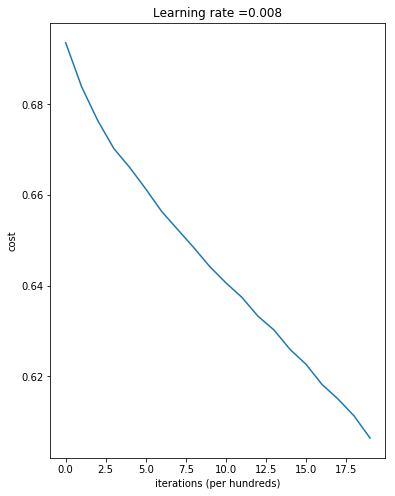

In [49]:
parameters = dnn_model(X_train, y_train, hidden_layers=[20,5,7], iterations=2000, learning_rate=0.008)

predictions = predict(X_test, parameters)

In [50]:
predictions = predict(X_train, parameters)
print("Accuracy Score - Training set: %f" % accuracy_score(y_train[0], predictions[0]))
print("Confusion Matrix:")
print(confusion_matrix(y_train[0], predictions[0]))

Accuracy Score - Training set: 0.680000
Confusion Matrix:
[[2126  409]
 [1191 1274]]


In [51]:
predictions = predict(X_test, parameters)
print("Accuracy Score: %f" % accuracy_score(y_test[0], predictions[0]))
print("Confusion Matrix:")
print(confusion_matrix(y_test[0], predictions[0]))

Accuracy Score: 0.640000
Confusion Matrix:
[[203  52]
 [128 117]]


Iteration 0, Cost: 0.693583
Iteration 100, Cost: 0.683828
Iteration 200, Cost: 0.676424
Iteration 300, Cost: 0.670269
Iteration 400, Cost: 0.666055
Iteration 500, Cost: 0.661321
Iteration 600, Cost: 0.656325
Iteration 700, Cost: 0.652350
Iteration 800, Cost: 0.648374
Iteration 900, Cost: 0.644187
Iteration 1000, Cost: 0.640628
Iteration 1100, Cost: 0.637424
Iteration 1200, Cost: 0.633277
Iteration 1300, Cost: 0.630239
Iteration 1400, Cost: 0.625957
Iteration 1500, Cost: 0.622673
Iteration 1600, Cost: 0.618211
Iteration 1700, Cost: 0.615000
Iteration 1800, Cost: 0.611286
Iteration 1900, Cost: 0.606389
Iteration 2000, Cost: 0.602006
Iteration 2100, Cost: 0.599284
Iteration 2200, Cost: 0.595855
Iteration 2300, Cost: 0.591408
Iteration 2400, Cost: 0.587994


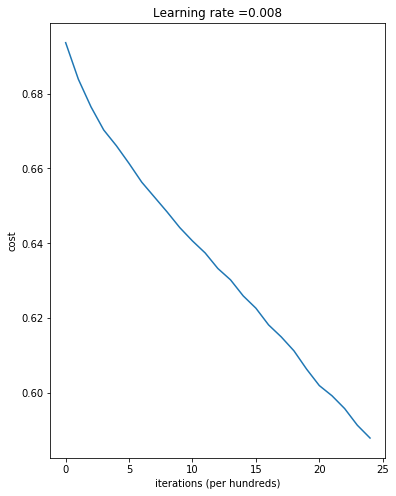

In [69]:
parameters_2 = dnn_model(X_train, y_train, hidden_layers=[20,5,7], iterations=2500, learning_rate=0.008)

predictions_2 = predict(X_test, parameters_2)

In [70]:
predictions = predict(X_train, parameters_2)
print("Accuracy Score - Training set: %f" % accuracy_score(y_train[0], predictions[0]))
print("Confusion Matrix:")
print(confusion_matrix(y_train[0], predictions[0]))

Accuracy Score - Training set: 0.699400
Confusion Matrix:
[[2109  426]
 [1077 1388]]


In [71]:
predictions = predict(X_test, parameters_2)
print("Accuracy Score: %f" % accuracy_score(y_test[0], predictions[0]))
print("Confusion Matrix:")
print(confusion_matrix(y_test[0], predictions[0]))

Accuracy Score: 0.640000
Confusion Matrix:
[[203  52]
 [128 117]]


In [62]:
import csv

In [ ]:
L = len(parameters)//2
csv_columns = []
for i in range(1,L+1):
    csv_columns.append('W'+str(i))
    csv_columns.append('b'+str(i))

In [ ]:
csv_file = "parameters.csv"
try:
    with open(csv_file, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
        writer.writeheader()
        for data in parameters:
            writer.writerow(data)
except IOError:
    print("I/O error") 

In [54]:
import pandas as pd

## Model from sklearn

Try a sklearn model to solve the problem, let's see if your model can overpass it.

In [41]:


# Create Logistics Regression model from X and y
lg = LogisticRegression()
lg.fit(X_train, y_train[0])

# Show metrics
print("Accuracy Score: %f" % accuracy_score(y_test[0], lg.predict(X_test)))
print("Confusion Matrix:")
print(confusion_matrix(y_test[0], lg.predict(X_test)))

Accuracy Score: 0.576000
Confusion Matrix:
[[130 125]
 [ 87 158]]
